In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
data = pd.read_csv("VietTri.csv", parse_dates=["date"], dayfirst=True, index_col=["date"])
data = data.sort_index()
start_date = '2019-03-01'
end_date = '2024-03-01'
df = data.loc[start_date:end_date]
df

,Index,pm25,pm10,o3,no2,so2,co,AQI
date,,,,,,,,
2019-10-26,717,81,47,22,11,19,11,81
2019-10-27,718,102,29,22,10,19,11,102
2019-10-28,719,69,24,22,10,19,11,69
2019-10-29,720,45,48,22,14,19,11,48
2019-10-30,721,94,48,22,13,19,11,94
...,...,...,...,...,...,...,...,...
2024-02-26,2240,31,10,23,4,9,8,31
2024-02-27,2241,16,25,23,5,9,8,25
2024-02-28,2242,37,15,23,4,9,8,37


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1532 entries, 2019-10-26 to 2024-03-01
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Index   1532 non-null   int64
 1   pm25    1532 non-null   int64
 2   pm10    1532 non-null   int64
 3   o3      1532 non-null   int64
 4   no2     1532 non-null   int64
 5   so2     1532 non-null   int64
 6   co      1532 non-null   int64
 7   AQI     1532 non-null   int64
dtypes: int64(8)
memory usage: 107.7 KB


In [4]:
df_aqi = pd.DataFrame(df["AQI"])

In [5]:
timesteps = df_aqi.index.values
aqi_arr = df_aqi["AQI"].values

In [6]:
timesteps

array(['2019-10-26T00:00:00.000000000', '2019-10-27T00:00:00.000000000',
       '2019-10-28T00:00:00.000000000', ...,
       '2024-02-28T00:00:00.000000000', '2024-02-29T00:00:00.000000000',
       '2024-03-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [7]:
aqi_arr

array([ 81, 102,  69, ...,  37,  23,  23])

**Building and testing he N-BEATS block layer**

In [8]:
class NBeatsBlock(tf.keras.layers.Layer):

  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon:    int,
               n_neurons:  int,
               n_layers:   int,
               **kwargs):


    super().__init__(**kwargs)
    self.input_size= input_size
    self.theta_size= theta_size
    self.horizon = horizon
    self.n_neurons= n_neurons
    self.n_layers= n_layers

    self.hidden=[tf.keras.layers.Dense(n_neurons, activation='relu', name=f"Fully_Connected_Layer_{i}") for i in range(1,n_layers+1) ]
    self.theta_layer=tf.keras.layers.Dense(theta_size, activation='linear',name='theta')


  def call(self,inputs):

    x= inputs

    for layer in self.hidden :
      x= layer(x)

    theta= self.theta_layer(x)

    # output the backcast and forecast
    backcast, forecast = theta[:,:self.input_size], theta[:,-self.horizon:]
    return backcast, forecast


In [9]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)


def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  return {
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mae": mae.numpy()}

In [10]:
WINDOW_SIZE=90
HORIZON=1
df_aqi

,AQI
date,
2019-10-26,81
2019-10-27,102
2019-10-28,69
2019-10-29,48
2019-10-30,94
...,...
2024-02-26,31
2024-02-27,25
2024-02-28,37


In [11]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  #Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  #Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for _ in range(into_future):

    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [12]:
aqi_nbeats = df_aqi.copy()
for i in range(WINDOW_SIZE):
  aqi_nbeats[f"AQI+{i+1}"] = aqi_nbeats["AQI"].shift(periods=i+1)
aqi_nbeats.dropna()

,AQI,AQI+1,AQI+2,AQI+3,AQI+4,AQI+5,AQI+6,AQI+7,AQI+8,AQI+9,...,AQI+81,AQI+82,AQI+83,AQI+84,AQI+85,AQI+86,AQI+87,AQI+88,AQI+89,AQI+90
date,,,,,,,,,,,,,,,,,,,,,
2020-01-26,16,26.0,37.0,93.0,70.0,72.0,70.0,55.0,64.0,51.0,...,67.0,56.0,56.0,80.0,90.0,94.0,48.0,69.0,102.0,81.0
2020-01-27,30,16.0,26.0,37.0,93.0,70.0,72.0,70.0,55.0,64.0,...,114.0,67.0,56.0,56.0,80.0,90.0,94.0,48.0,69.0,102.0
2020-01-28,46,30.0,16.0,26.0,37.0,93.0,70.0,72.0,70.0,55.0,...,153.0,114.0,67.0,56.0,56.0,80.0,90.0,94.0,48.0,69.0
2020-01-29,77,46.0,30.0,16.0,26.0,37.0,93.0,70.0,72.0,70.0,...,157.0,153.0,114.0,67.0,56.0,56.0,80.0,90.0,94.0,48.0
2020-01-30,88,77.0,46.0,30.0,16.0,26.0,37.0,93.0,70.0,72.0,...,135.0,157.0,153.0,114.0,67.0,56.0,56.0,80.0,90.0,94.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,31,23.0,23.0,50.0,52.0,70.0,76.0,50.0,51.0,65.0,...,35.0,113.0,117.0,102.0,86.0,75.0,90.0,94.0,84.0,100.0
2024-02-27,25,31.0,23.0,23.0,50.0,52.0,70.0,76.0,50.0,51.0,...,50.0,35.0,113.0,117.0,102.0,86.0,75.0,90.0,94.0,84.0
2024-02-28,37,25.0,31.0,23.0,23.0,50.0,52.0,70.0,76.0,50.0,...,68.0,50.0,35.0,113.0,117.0,102.0,86.0,75.0,90.0,94.0


**NBEATS(7:3)**

In [13]:
# Make features and labels
x = aqi_nbeats.drop("AQI", axis=1)
y = aqi_nbeats["AQI"]
x.fillna(method='ffill', inplace=True)
x.fillna(method='bfill', inplace=True)
y.fillna(method='ffill', inplace=True)
y.fillna(method='bfill', inplace=True)

In [14]:
split_size = int(len(x) * 0.7)
x_train, y_train = x[:split_size], y[:split_size]
x_test, y_test = x[split_size:], y[split_size:]
len(x_train), len(y_train), len(x_test), len(y_test)

(1072, 1072, 460, 460)

In [15]:
#Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

#Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 90), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 90), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

**Setting up hyperparameters for N-BEATS algorithm**

In [16]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 20 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30
INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON
INPUT_SIZE, THETA_SIZE

(90, 91)

**Getting ready for residual connections**

In [17]:
# trying tf.keras.layers.add or .subtract
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

subtracted = tf.keras.layers.subtract([tensor_1,tensor_2])
added = tf.keras.layers.add([tensor_1,tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


**Building, compiling and fitting the N-BEATS algorithm**

In [18]:
tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)

residuals = tf.keras.layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

In [19]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 499ms/step - loss: 14.7729 - mae: 14.7729 - mse: 425.8562


[14.77293586730957, 14.77293586730957, 425.856201171875]

In [20]:
model_preds = make_preds(model, test_dataset)
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

1/1 [==============================] - 2s 2s/step


{'rmse': 20.636284, 'mape': 26.018936, 'mae': 14.772936}

**Make predictions into future**

In [21]:
INTO_FUTURE = 30
future_forecast_30 = make_future_forecast(values=y,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

future_forecast_60 = make_future_forecast(values=y,
                                       model=model,
                                       into_future=INTO_FUTURE+30,
                                       window_size=WINDOW_SIZE)
future_forecast_90 = make_future_forecast(values=y,
                                       model=model,
                                       into_future=INTO_FUTURE+60,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 2s 2s/step
Predicting on: 
 date
2023-11-27     86
2023-11-28    102
2023-11-29    117
2023-11-30    113
2023-12-01     35
             ... 
2024-02-26     31
2024-02-27     25
2024-02-28     37
2024-02-29     23
2024-03-01     23
Name: AQI, Length: 90, dtype: int64 -> Prediction: 58.41179656982422

1/1 [==============================] - 2s 2s/step
Predicting on: 
 [102.         117.         113.          35.          50.
  68.          35.          41.          38.          52.
  88.          88.         101.         101.          84.
  69.          75.          64.          58.          33.
  39.          28.          24.          44.          53.
  58.          66.          65.          91.          92.
  80.          93.          89.          66.          75.
  81.          46.          63.          56.          55.
  70.          66.          60.          37.          23.
  23.          25.          38.          58.          47.
  36.        

In [22]:
y_train = aqi_arr[:split_size]
y_test = aqi_arr[split_size:]
len(y_train), len(y_test)

(1072, 460)

In [23]:
test_size = len(df)-split_size

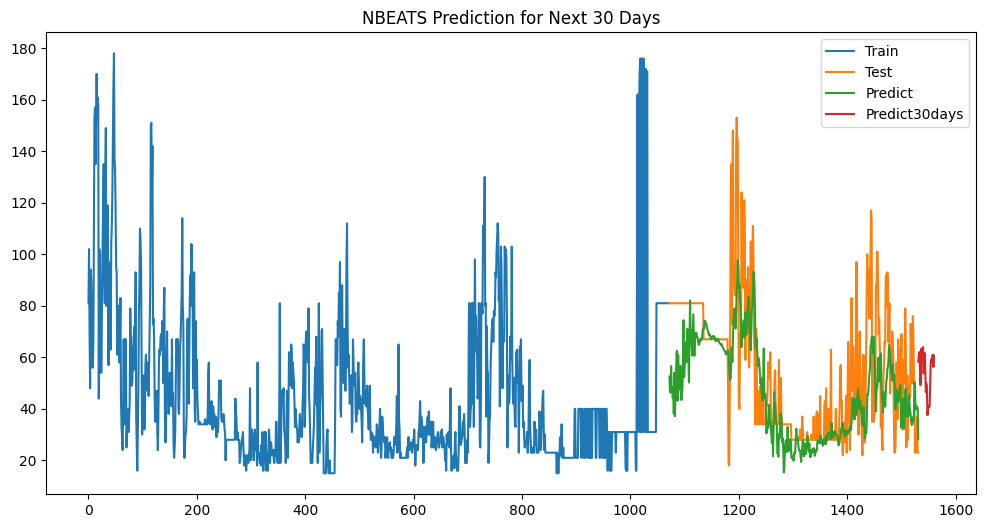

In [24]:
plt.figure(figsize=(12, 6))
future_forecast_array = np.array(future_forecast_30)
train_data_index = pd.RangeIndex(start=0, stop=split_size, step=1)
plt.plot(y_train)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
plt.plot(test_data_index,y_test)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
len(test_data_index)
plt.plot(test_data_index,model_preds)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
plt.plot(prediect_data_index,future_forecast_array)
plt.title('NBEATS Prediction for Next 30 Days')
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

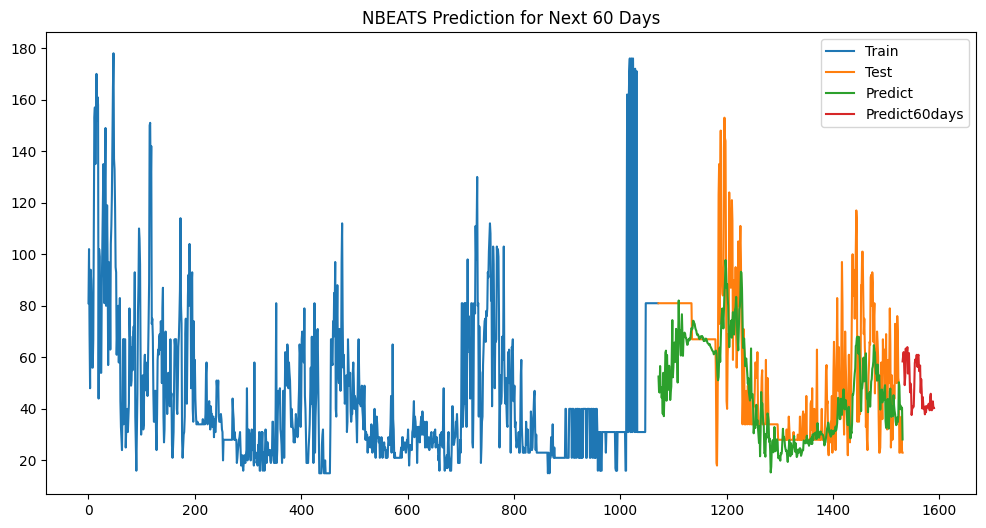

In [25]:
plt.figure(figsize=(12, 6))
future_forecast_array_60 = np.array(future_forecast_60)
train_data_index = pd.RangeIndex(start=0, stop=split_size, step=1)
plt.plot(y_train)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
plt.plot(test_data_index,y_test)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
len(test_data_index)
plt.plot(test_data_index,model_preds)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+59, step=1)
plt.plot(prediect_data_index,future_forecast_array_60)
plt.title('NBEATS Prediction for Next 60 Days')
plt.legend(['Train','Test','Predict','Predict60days'])
plt.show()

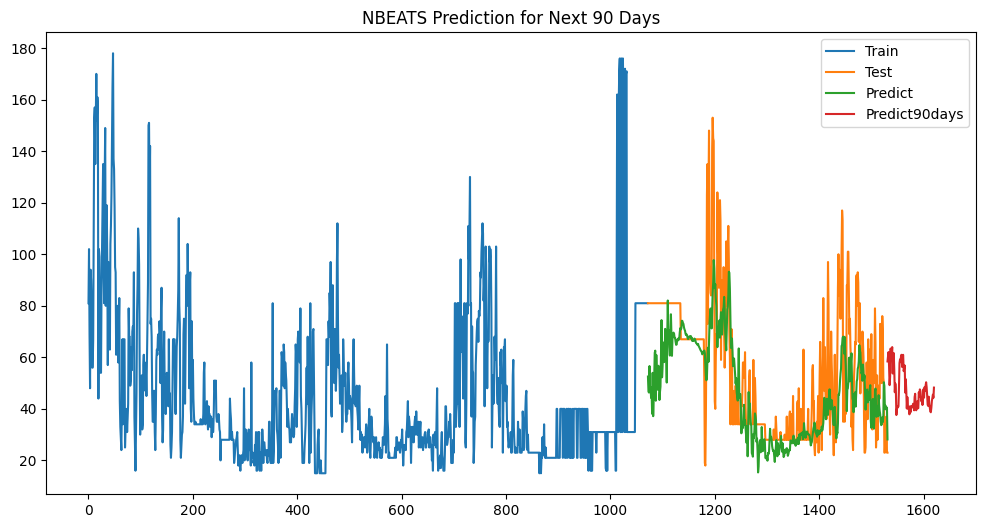

In [26]:
plt.figure(figsize=(12, 6))
future_forecast_array_90 = np.array(future_forecast_90)
train_data_index = pd.RangeIndex(start=0, stop=split_size, step=1)
plt.plot(y_train)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
plt.plot(test_data_index,y_test)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
len(test_data_index)
plt.plot(test_data_index,model_preds)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+89, step=1)
plt.plot(prediect_data_index,future_forecast_array_90)
plt.title('NBEATS Prediction for Next 90 Days')
plt.legend(['Train','Test','Predict','Predict90days'])
plt.show()

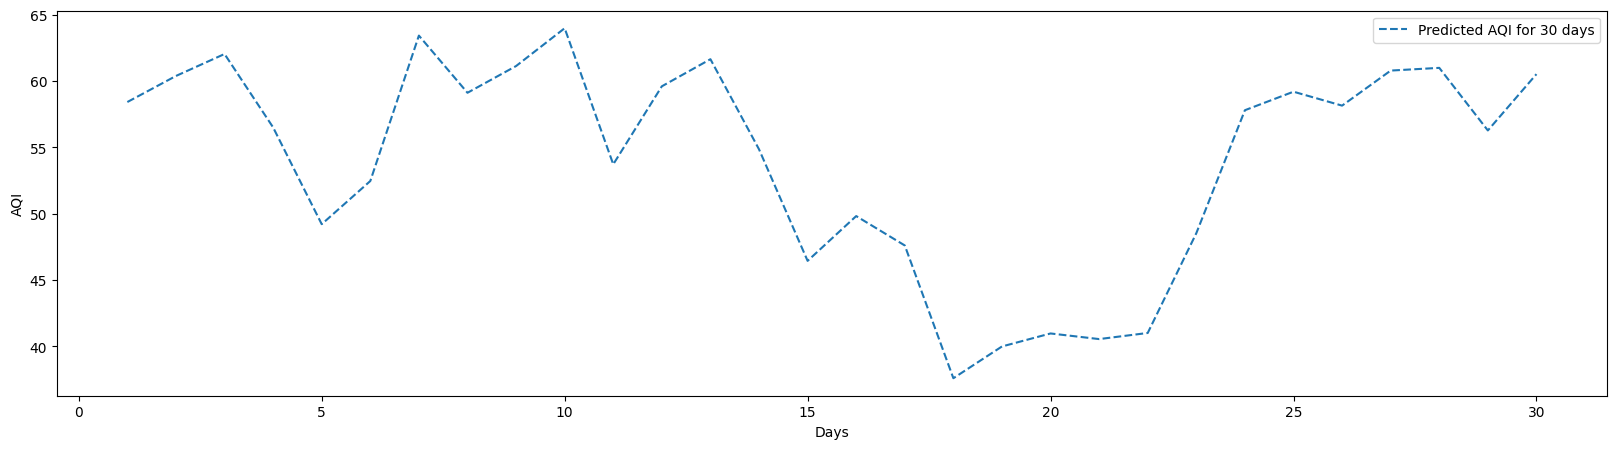

In [27]:
plt.figure(figsize=(20,5))
plt.plot(range(1, 30 + 1), future_forecast_30 , label=f'Predicted AQI for {30} days', linestyle='--')
plt.xlabel('Days')
plt.ylabel('AQI')
plt.legend()
plt.show()

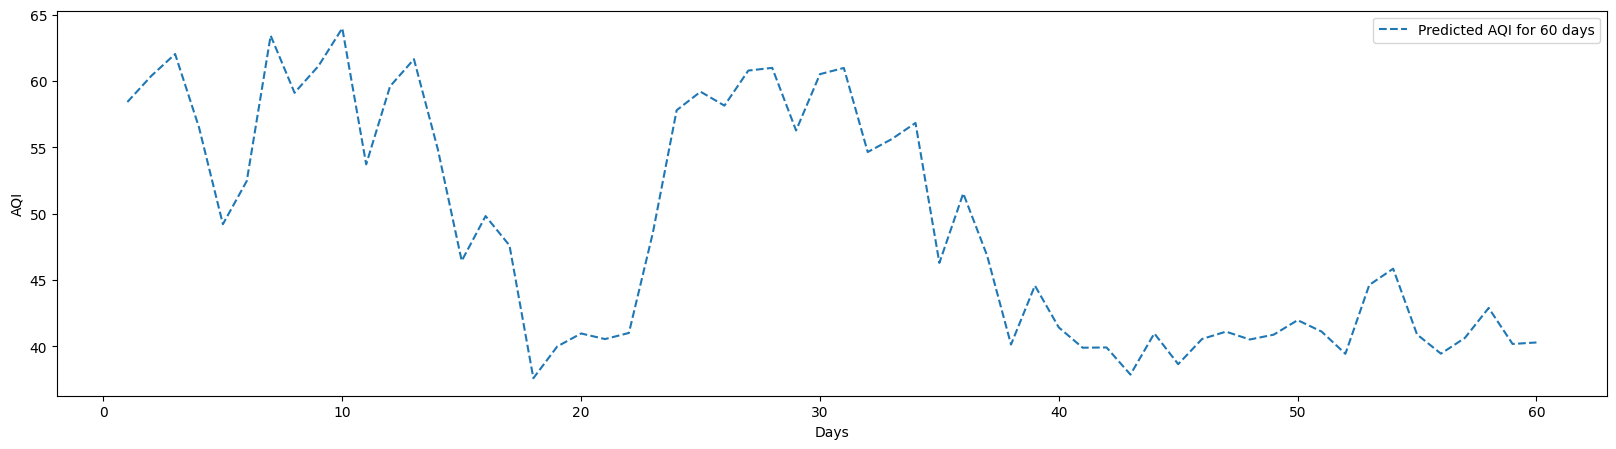

In [28]:
plt.figure(figsize=(20,5))
plt.plot(range(1, 60 + 1), future_forecast_60 , label=f'Predicted AQI for {60} days', linestyle='--')
plt.xlabel('Days')
plt.ylabel('AQI')
plt.legend()
plt.show()

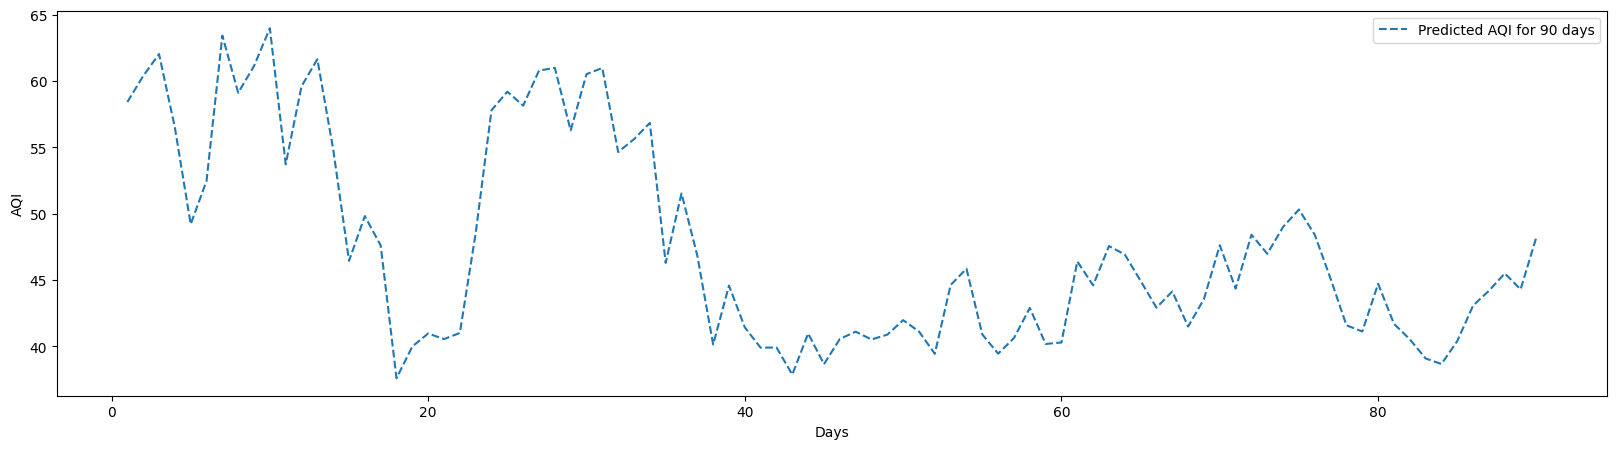

In [29]:
plt.figure(figsize=(20,5))
plt.plot(range(1, 90 + 1), future_forecast_90 , label=f'Predicted AQI for {90} days', linestyle='--')
plt.xlabel('Days')
plt.ylabel('AQI')
plt.legend()
plt.show()

**NBEATS(8:2)**


In [30]:
WINDOW_SIZE=90
HORIZON=1
df_aqi

,AQI
date,
2019-10-26,81
2019-10-27,102
2019-10-28,69
2019-10-29,48
2019-10-30,94
...,...
2024-02-26,31
2024-02-27,25
2024-02-28,37


In [31]:
aqi_nbeats = df_aqi.copy()
for i in range(WINDOW_SIZE):
  aqi_nbeats[f"AQI+{i+1}"] = aqi_nbeats["AQI"].shift(periods=i+1)
aqi_nbeats.dropna()

,AQI,AQI+1,AQI+2,AQI+3,AQI+4,AQI+5,AQI+6,AQI+7,AQI+8,AQI+9,...,AQI+81,AQI+82,AQI+83,AQI+84,AQI+85,AQI+86,AQI+87,AQI+88,AQI+89,AQI+90
date,,,,,,,,,,,,,,,,,,,,,
2020-01-26,16,26.0,37.0,93.0,70.0,72.0,70.0,55.0,64.0,51.0,...,67.0,56.0,56.0,80.0,90.0,94.0,48.0,69.0,102.0,81.0
2020-01-27,30,16.0,26.0,37.0,93.0,70.0,72.0,70.0,55.0,64.0,...,114.0,67.0,56.0,56.0,80.0,90.0,94.0,48.0,69.0,102.0
2020-01-28,46,30.0,16.0,26.0,37.0,93.0,70.0,72.0,70.0,55.0,...,153.0,114.0,67.0,56.0,56.0,80.0,90.0,94.0,48.0,69.0
2020-01-29,77,46.0,30.0,16.0,26.0,37.0,93.0,70.0,72.0,70.0,...,157.0,153.0,114.0,67.0,56.0,56.0,80.0,90.0,94.0,48.0
2020-01-30,88,77.0,46.0,30.0,16.0,26.0,37.0,93.0,70.0,72.0,...,135.0,157.0,153.0,114.0,67.0,56.0,56.0,80.0,90.0,94.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,31,23.0,23.0,50.0,52.0,70.0,76.0,50.0,51.0,65.0,...,35.0,113.0,117.0,102.0,86.0,75.0,90.0,94.0,84.0,100.0
2024-02-27,25,31.0,23.0,23.0,50.0,52.0,70.0,76.0,50.0,51.0,...,50.0,35.0,113.0,117.0,102.0,86.0,75.0,90.0,94.0,84.0
2024-02-28,37,25.0,31.0,23.0,23.0,50.0,52.0,70.0,76.0,50.0,...,68.0,50.0,35.0,113.0,117.0,102.0,86.0,75.0,90.0,94.0


In [32]:
# Make features and labels
x = aqi_nbeats.drop("AQI", axis=1)
y = aqi_nbeats["AQI"]
x.fillna(method='ffill', inplace=True)
x.fillna(method='bfill', inplace=True)
y.fillna(method='ffill', inplace=True)
y.fillna(method='bfill', inplace=True)

In [33]:
split_size = int(len(x) * 0.8)
x_train, y_train = x[:split_size], y[:split_size]
x_test, y_test = x[split_size:], y[split_size:]
len(x_train), len(y_train), len(x_test), len(y_test)

(1225, 1225, 307, 307)

In [34]:
#Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

#Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 90), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 90), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [35]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 20 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30
INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON
INPUT_SIZE, THETA_SIZE

(90, 91)

In [36]:
# trying tf.keras.layers.add or .subtract
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

subtracted = tf.keras.layers.subtract([tensor_1,tensor_2])
added = tf.keras.layers.add([tensor_1,tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [37]:
tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)

residuals = tf.keras.layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

In [38]:
model.evaluate(test_dataset)

1/1 [==============================] - 1s 513ms/step - loss: 15.9986 - mae: 15.9986 - mse: 390.6023


[15.99858570098877, 15.99858570098877, 390.6022644042969]

In [39]:
model_preds = make_preds(model, test_dataset)
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

1/1 [==============================] - 2s 2s/step


{'rmse': 19.76366, 'mape': 43.13251, 'mae': 15.998586}

In [40]:
INTO_FUTURE = 30
future_forecast_30 = make_future_forecast(values=y,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

future_forecast_60 = make_future_forecast(values=y,
                                       model=model,
                                       into_future=INTO_FUTURE+30,
                                       window_size=WINDOW_SIZE)
future_forecast_90 = make_future_forecast(values=y,
                                       model=model,
                                       into_future=INTO_FUTURE+60,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 2s 2s/step
Predicting on: 
 date
2023-11-27     86
2023-11-28    102
2023-11-29    117
2023-11-30    113
2023-12-01     35
             ... 
2024-02-26     31
2024-02-27     25
2024-02-28     37
2024-02-29     23
2024-03-01     23
Name: AQI, Length: 90, dtype: int64 -> Prediction: 90.1031723022461

1/1 [==============================] - 2s 2s/step
Predicting on: 
 [102.        117.        113.         35.         50.         68.
  35.         41.         38.         52.         88.         88.
 101.        101.         84.         69.         75.         64.
  58.         33.         39.         28.         24.         44.
  53.         58.         66.         65.         91.         92.
  80.         93.         89.         66.         75.         81.
  46.         63.         56.         55.         70.         66.
  60.         37.         23.         23.         25.         38.
  58.         47.         36.         67.         54.         59.


In [41]:
y_train = aqi_arr[:split_size]
y_train = aqi_arr[:split_size]
y_test = aqi_arr[split_size:]
len(y_train), len(y_test)
test_size = len(df)-split_size
future_forecast_array = np.array(future_forecast_30)

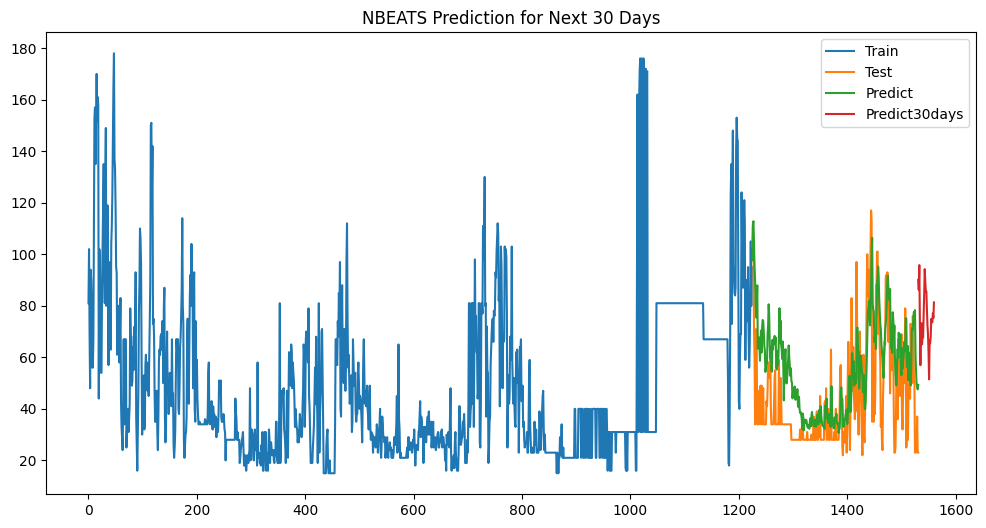

In [42]:
plt.figure(figsize=(12, 6))
train_data_index = pd.RangeIndex(start=0, stop=split_size, step=1)
plt.plot(y_train)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
plt.plot(test_data_index,y_test)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
len(test_data_index)
plt.plot(test_data_index,model_preds)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
plt.plot(prediect_data_index,future_forecast_array)
plt.title('NBEATS Prediction for Next 30 Days')
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

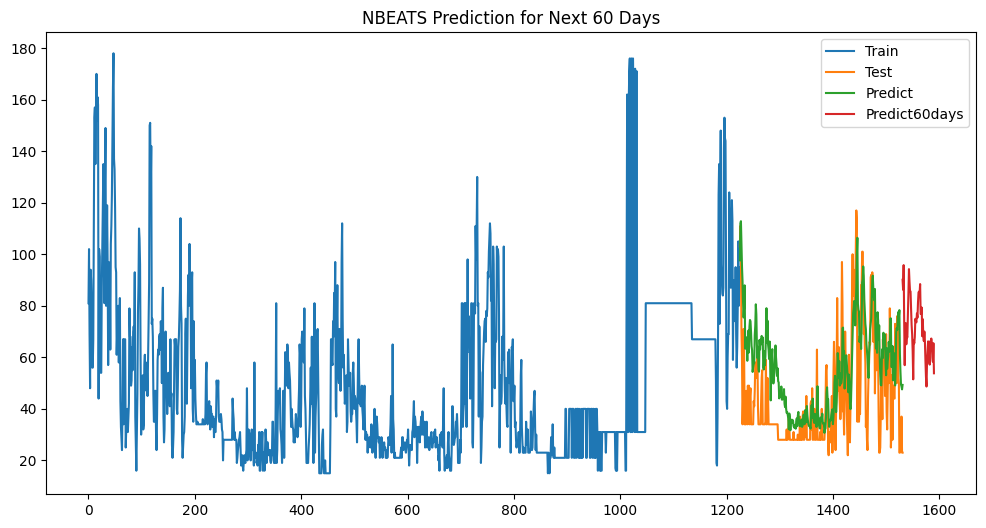

In [43]:
plt.figure(figsize=(12, 6))
future_forecast_array_60 = np.array(future_forecast_60)
train_data_index = pd.RangeIndex(start=0, stop=split_size, step=1)
plt.plot(y_train)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
plt.plot(test_data_index,y_test)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
len(test_data_index)
plt.plot(test_data_index,model_preds)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+59, step=1)
plt.plot(prediect_data_index,future_forecast_array_60)
plt.title('NBEATS Prediction for Next 60 Days')
plt.legend(['Train','Test','Predict','Predict60days'])
plt.show()

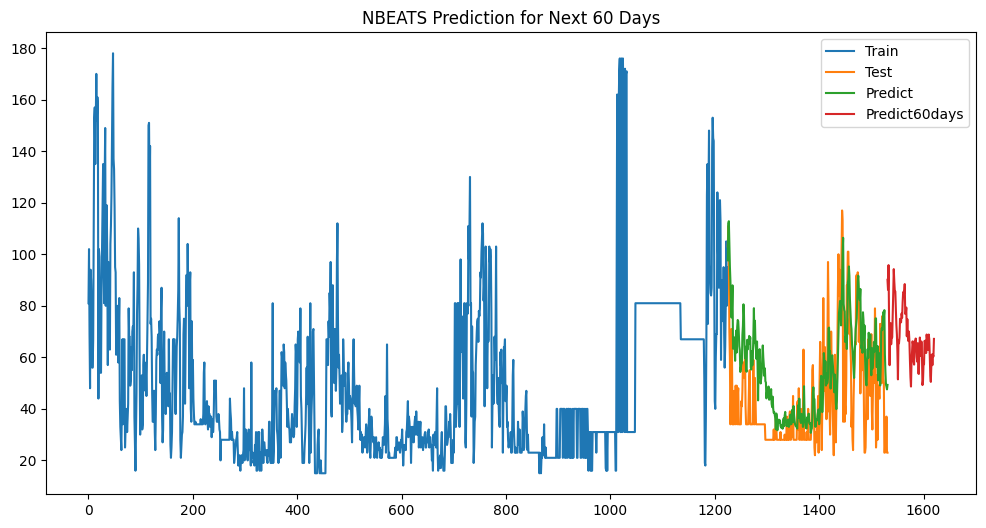

In [44]:
plt.figure(figsize=(12, 6))
future_forecast_array_90 = np.array(future_forecast_90)
train_data_index = pd.RangeIndex(start=0, stop=split_size, step=1)
plt.plot(y_train)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
plt.plot(test_data_index,y_test)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
len(test_data_index)
plt.plot(test_data_index,model_preds)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+89, step=1)
plt.plot(prediect_data_index,future_forecast_array_90)
plt.title('NBEATS Prediction for Next 60 Days')
plt.legend(['Train','Test','Predict','Predict60days'])
plt.show()

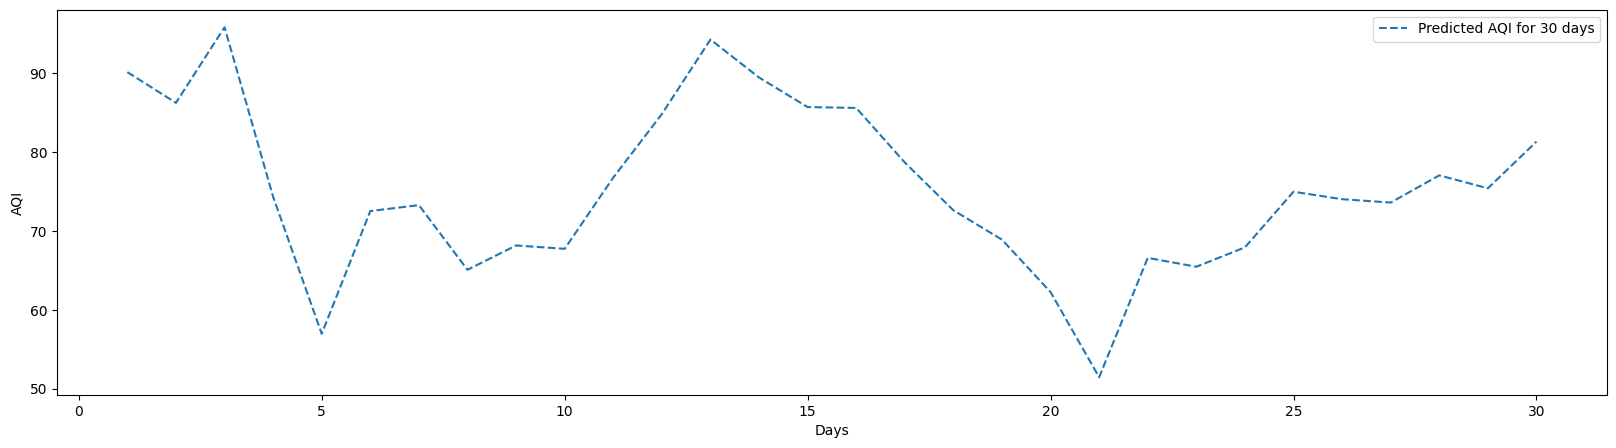

In [45]:
plt.figure(figsize=(20,5))
plt.plot(range(1, 30 + 1), future_forecast_30 , label=f'Predicted AQI for {30} days', linestyle='--')
plt.xlabel('Days')
plt.ylabel('AQI')
plt.legend()
plt.show()

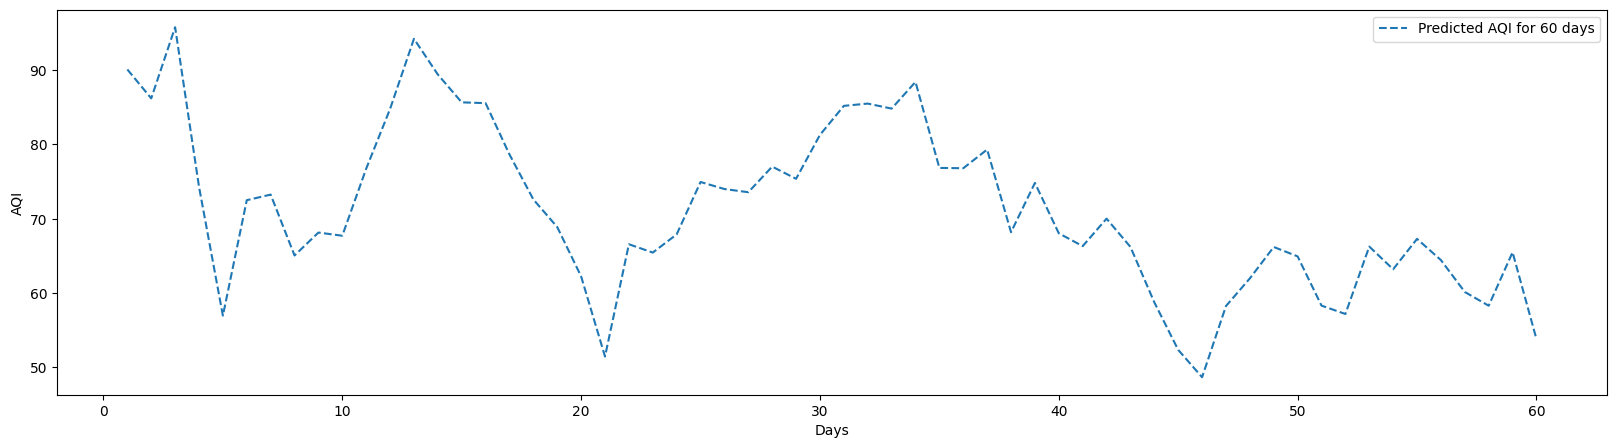

In [46]:
plt.figure(figsize=(20,5))
plt.plot(range(1, 60 + 1), future_forecast_60 , label=f'Predicted AQI for {60} days', linestyle='--')
plt.xlabel('Days')
plt.ylabel('AQI')
plt.legend()
plt.show()

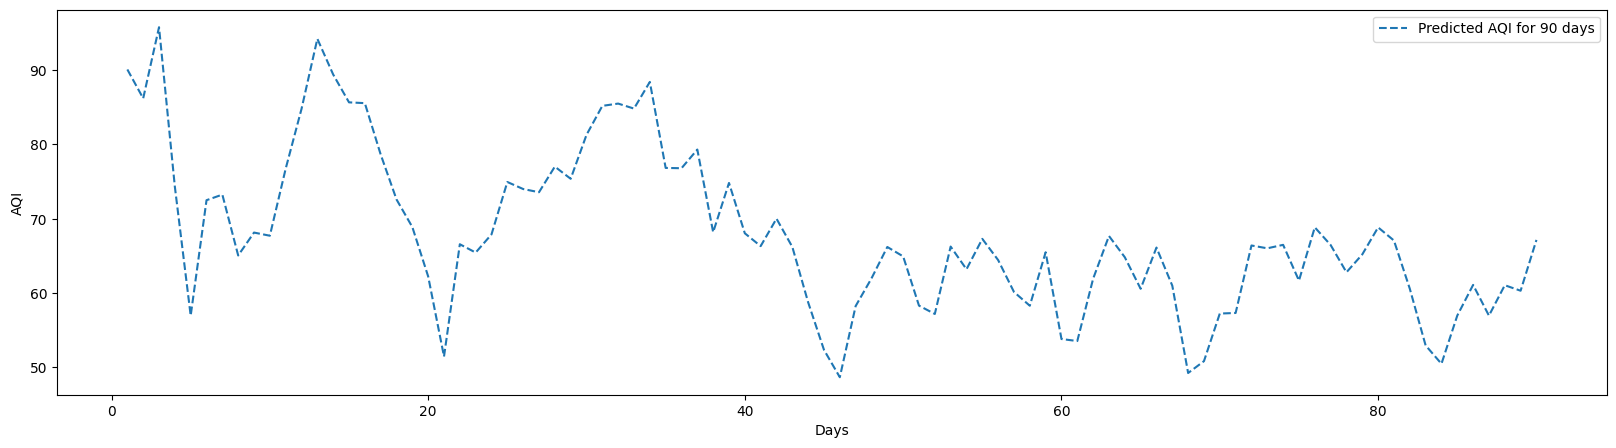

In [47]:
plt.figure(figsize=(20,5))
plt.plot(range(1, 90 + 1), future_forecast_90 , label=f'Predicted AQI for {90} days', linestyle='--')
plt.xlabel('Days')
plt.ylabel('AQI')
plt.legend()
plt.show()

**NBEAT(9:1)**

In [48]:
WINDOW_SIZE=90
HORIZON=1
aqi_nbeats = df_aqi.copy()
for i in range(WINDOW_SIZE):
  aqi_nbeats[f"AQI+{i+1}"] = aqi_nbeats["AQI"].shift(periods=i+1)
aqi_nbeats.dropna()

,AQI,AQI+1,AQI+2,AQI+3,AQI+4,AQI+5,AQI+6,AQI+7,AQI+8,AQI+9,...,AQI+81,AQI+82,AQI+83,AQI+84,AQI+85,AQI+86,AQI+87,AQI+88,AQI+89,AQI+90
date,,,,,,,,,,,,,,,,,,,,,
2020-01-26,16,26.0,37.0,93.0,70.0,72.0,70.0,55.0,64.0,51.0,...,67.0,56.0,56.0,80.0,90.0,94.0,48.0,69.0,102.0,81.0
2020-01-27,30,16.0,26.0,37.0,93.0,70.0,72.0,70.0,55.0,64.0,...,114.0,67.0,56.0,56.0,80.0,90.0,94.0,48.0,69.0,102.0
2020-01-28,46,30.0,16.0,26.0,37.0,93.0,70.0,72.0,70.0,55.0,...,153.0,114.0,67.0,56.0,56.0,80.0,90.0,94.0,48.0,69.0
2020-01-29,77,46.0,30.0,16.0,26.0,37.0,93.0,70.0,72.0,70.0,...,157.0,153.0,114.0,67.0,56.0,56.0,80.0,90.0,94.0,48.0
2020-01-30,88,77.0,46.0,30.0,16.0,26.0,37.0,93.0,70.0,72.0,...,135.0,157.0,153.0,114.0,67.0,56.0,56.0,80.0,90.0,94.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,31,23.0,23.0,50.0,52.0,70.0,76.0,50.0,51.0,65.0,...,35.0,113.0,117.0,102.0,86.0,75.0,90.0,94.0,84.0,100.0
2024-02-27,25,31.0,23.0,23.0,50.0,52.0,70.0,76.0,50.0,51.0,...,50.0,35.0,113.0,117.0,102.0,86.0,75.0,90.0,94.0,84.0
2024-02-28,37,25.0,31.0,23.0,23.0,50.0,52.0,70.0,76.0,50.0,...,68.0,50.0,35.0,113.0,117.0,102.0,86.0,75.0,90.0,94.0


In [49]:
# Make features and labels
x = aqi_nbeats.drop("AQI", axis=1)
y = aqi_nbeats["AQI"]
x.fillna(method='ffill', inplace=True)
x.fillna(method='bfill', inplace=True)
y.fillna(method='ffill', inplace=True)
y.fillna(method='bfill', inplace=True)

In [50]:
split_size = int(len(x) * 0.9)
x_train, y_train = x[:split_size], y[:split_size]
x_test, y_test = x[split_size:], y[split_size:]
len(x_train), len(y_train), len(x_test), len(y_test)

(1378, 1378, 154, 154)

In [51]:
#Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

#Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 90), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 90), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [52]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 20 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30
INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON
INPUT_SIZE, THETA_SIZE

(90, 91)

In [53]:
# trying tf.keras.layers.add or .subtract
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

subtracted = tf.keras.layers.subtract([tensor_1,tensor_2])
added = tf.keras.layers.add([tensor_1,tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [54]:
tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)

residuals = tf.keras.layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

In [55]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 193ms/step - loss: 15.1803 - mae: 15.1803 - mse: 374.7610


[15.180328369140625, 15.180328369140625, 374.76104736328125]

In [56]:
model_preds = make_preds(model, test_dataset)
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

1/1 [==============================] - 2s 2s/step


{'rmse': 19.358746, 'mape': 37.762646, 'mae': 15.180328}

In [57]:
INTO_FUTURE = 30
future_forecast_30 = make_future_forecast(values=y,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

future_forecast_60 = make_future_forecast(values=y,
                                       model=model,
                                       into_future=INTO_FUTURE+30,
                                       window_size=WINDOW_SIZE)
future_forecast_90 = make_future_forecast(values=y,
                                       model=model,
                                       into_future=INTO_FUTURE+60,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 2s 2s/step
Predicting on: 
 date
2023-11-27     86
2023-11-28    102
2023-11-29    117
2023-11-30    113
2023-12-01     35
             ... 
2024-02-26     31
2024-02-27     25
2024-02-28     37
2024-02-29     23
2024-03-01     23
Name: AQI, Length: 90, dtype: int64 -> Prediction: 90.91693878173828

1/1 [==============================] - 2s 2s/step
Predicting on: 
 [102.         117.         113.          35.          50.
  68.          35.          41.          38.          52.
  88.          88.         101.         101.          84.
  69.          75.          64.          58.          33.
  39.          28.          24.          44.          53.
  58.          66.          65.          91.          92.
  80.          93.          89.          66.          75.
  81.          46.          63.          56.          55.
  70.          66.          60.          37.          23.
  23.          25.          38.          58.          47.
  36.        

In [58]:
y_train = aqi_arr[:split_size]
y_train = aqi_arr[:split_size]
y_test = aqi_arr[split_size:]
len(y_train), len(y_test)
test_size = len(df)-split_size
future_forecast_array = np.array(future_forecast_30)

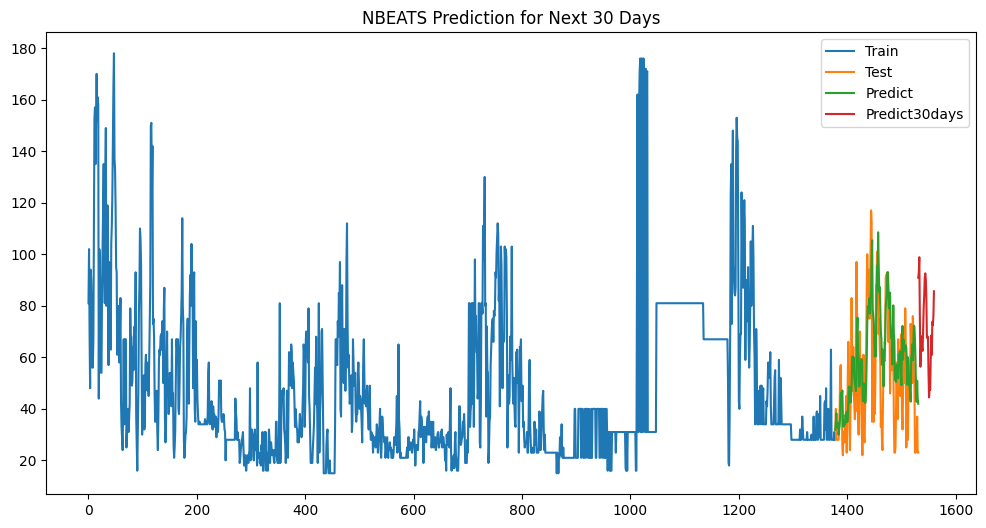

In [59]:
plt.figure(figsize=(12, 6))
train_data_index = pd.RangeIndex(start=0, stop=split_size, step=1)
plt.plot(y_train)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
plt.plot(test_data_index,y_test)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
len(test_data_index)
plt.plot(test_data_index,model_preds)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
plt.plot(prediect_data_index,future_forecast_array)
plt.title('NBEATS Prediction for Next 30 Days')
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

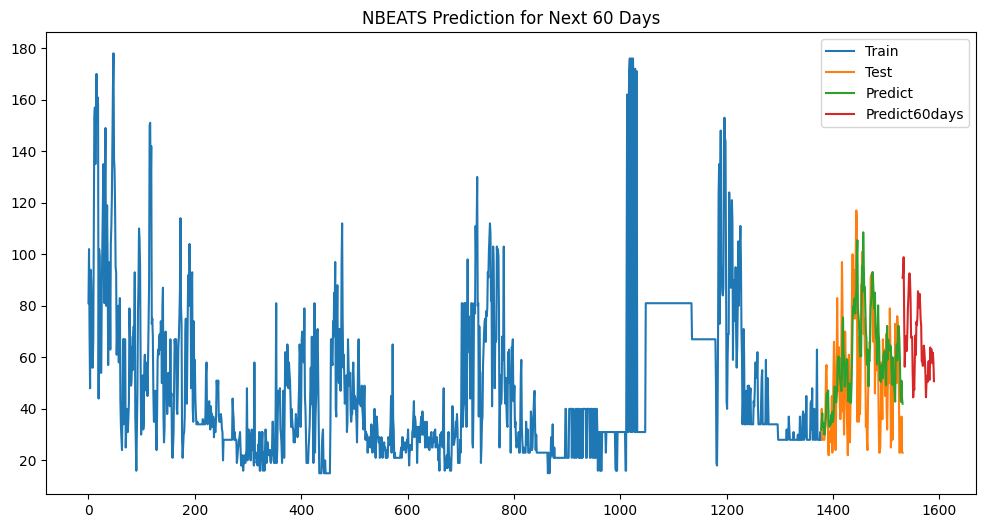

In [60]:
plt.figure(figsize=(12, 6))
future_forecast_array_60 = np.array(future_forecast_60)
train_data_index = pd.RangeIndex(start=0, stop=split_size, step=1)
plt.plot(y_train)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
plt.plot(test_data_index,y_test)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
len(test_data_index)
plt.plot(test_data_index,model_preds)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+59, step=1)
plt.plot(prediect_data_index,future_forecast_array_60)
plt.title('NBEATS Prediction for Next 60 Days')
plt.legend(['Train','Test','Predict','Predict60days'])
plt.show()

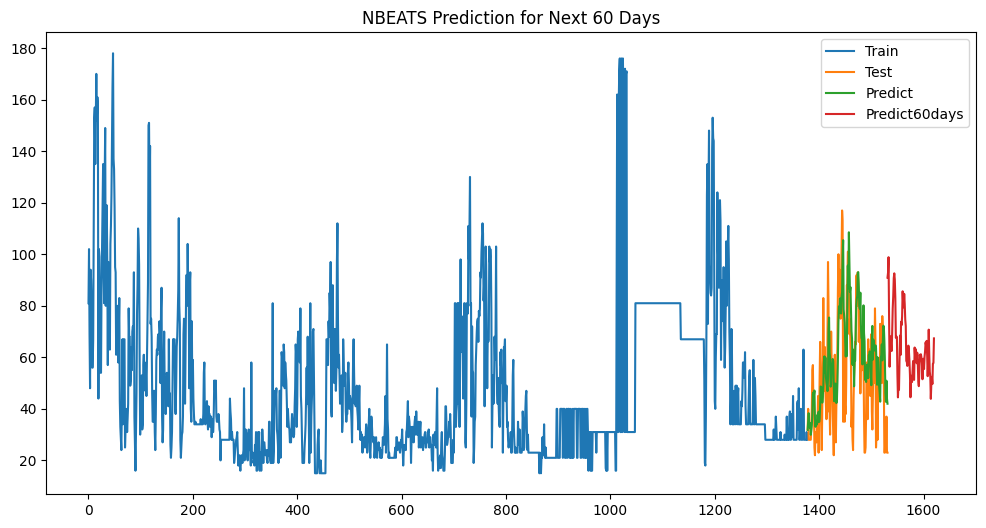

In [61]:
plt.figure(figsize=(12, 6))
future_forecast_array_90 = np.array(future_forecast_90)
train_data_index = pd.RangeIndex(start=0, stop=split_size, step=1)
plt.plot(y_train)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
plt.plot(test_data_index,y_test)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
len(test_data_index)
plt.plot(test_data_index,model_preds)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+89, step=1)
plt.plot(prediect_data_index,future_forecast_array_90)
plt.title('NBEATS Prediction for Next 60 Days')
plt.legend(['Train','Test','Predict','Predict60days'])
plt.show()

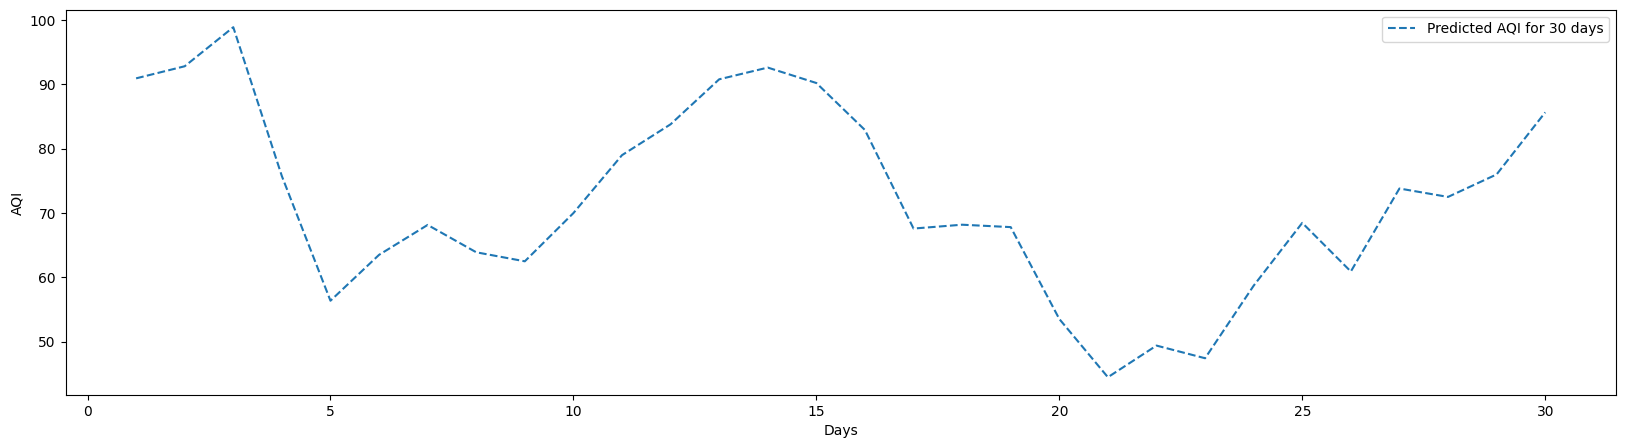

In [62]:
plt.figure(figsize=(20,5))
plt.plot(range(1, 30 + 1), future_forecast_30 , label=f'Predicted AQI for {30} days', linestyle='--')
plt.xlabel('Days')
plt.ylabel('AQI')
plt.legend()
plt.show()

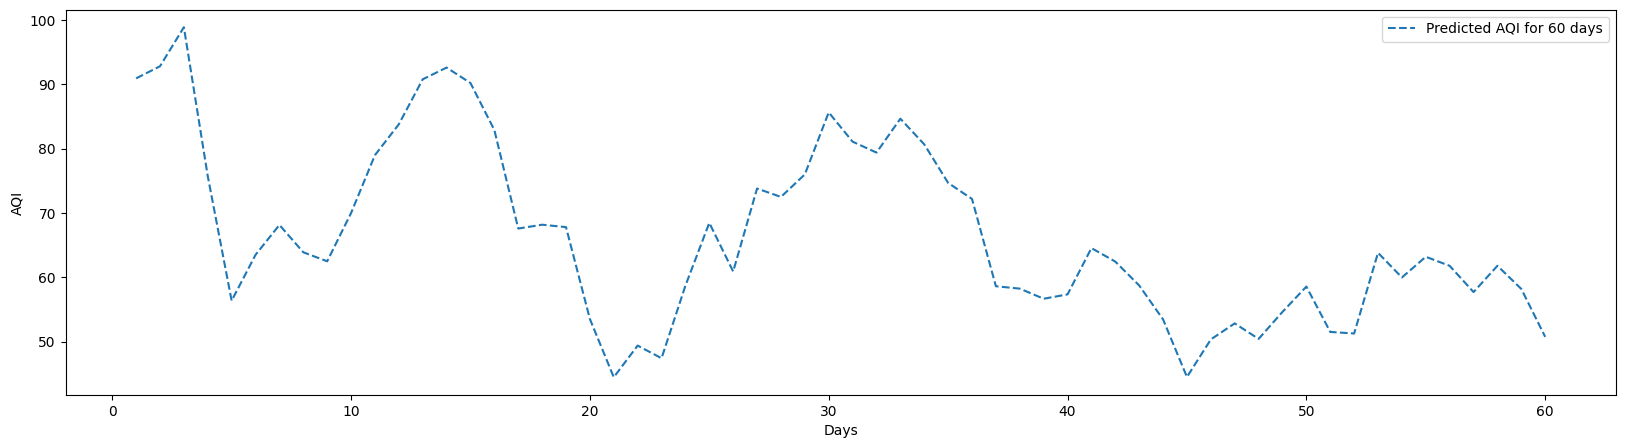

In [63]:
plt.figure(figsize=(20,5))
plt.plot(range(1, 60 + 1), future_forecast_60 , label=f'Predicted AQI for {60} days', linestyle='--')
plt.xlabel('Days')
plt.ylabel('AQI')
plt.legend()
plt.show()

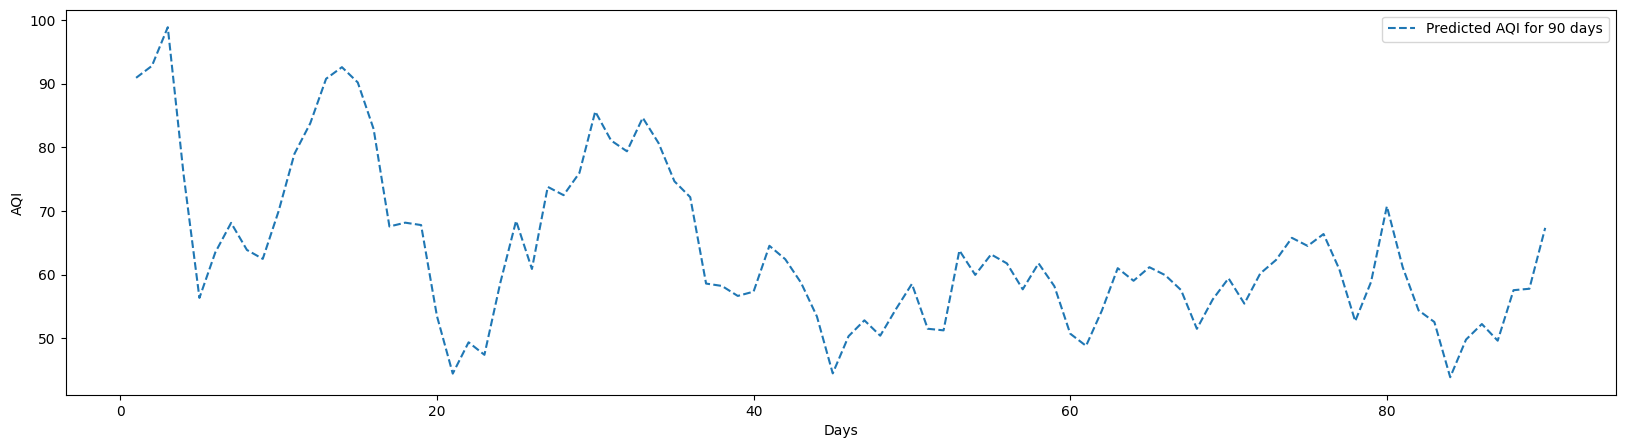

In [64]:
plt.figure(figsize=(20,5))
plt.plot(range(1, 90 + 1), future_forecast_90 , label=f'Predicted AQI for {90} days', linestyle='--')
plt.xlabel('Days')
plt.ylabel('AQI')
plt.legend()
plt.show()